In [ ]:
# обучим catboost на всех датасетах и проверим качество

In [1]:
# add trojan detecting chalange kit to path
import sys
sys.path.insert(0, '/root/course_project/tdc_starter_kit/')


In [2]:
import sys
print(sys.version)
# import solution
import importlib
# importlib.reload(solution)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
print(torch.cuda.is_available())


import torch
# fix for torch transformer
class GELU(torch.nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.gelu(input)
torch.nn.modules.activation.GELU = GELU

import torchvision
import trojanvision
import trojanzoo
import argparse

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil
import os
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random
import subprocess

from torchvision import transforms
import torch
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from torchsummary import summary



from typing import TYPE_CHECKING
import argparse
from collections.abc import Callable
if TYPE_CHECKING:
    import torch.utils.data
import json
from tdc_starter_kit import utils

seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
True


In [3]:
datasets = ["mnist", "cifar10", "gtsrb"]

test_df = pd.DataFrame()
train_df = pd.DataFrame()

test_lables = np.array([])
train_lables = np.array([])
test_datasets_dict = {}
train_datasets_dict = {}
test_lables_dict = {}
train_lables_dict = {}



for dname in tqdm(datasets, leave=False):
    tmp_test = pd.read_csv(f"{dname}_test.pd.csv", index_col=0)
    test_df = pd.concat([test_df, tmp_test], ignore_index=True, copy=False)
    test_datasets_dict[dname] = tmp_test
    
    tmp_train = pd.read_csv(f"{dname}_train.pd.csv", index_col=0)
    train_df = pd.concat([train_df, tmp_train], ignore_index=True, copy=False)
    train_datasets_dict[dname] = tmp_train
    
    tmp_test_lables = np.load(f"{dname}_test_lables_1d.np.npy")
    test_lables = np.concatenate([test_lables, tmp_test_lables])
    test_lables_dict[dname] = tmp_test_lables
    
    tmp_train_lables = np.load(f"{dname}_train_lables_1d.np.npy")
    train_lables = np.concatenate([train_lables, tmp_train_lables])
    train_lables_dict[dname] = tmp_train_lables

In [4]:
train_datasets_dict["cifar10"] = train_datasets_dict["cifar10"].assign(classifier_ensurance=train_datasets_dict["cifar10"].classifier_ensurance_first)

In [5]:
train_datasets_dict["mnist"] = train_datasets_dict["mnist"].assign(classifier_ensurance=train_datasets_dict["mnist"].classifier_ensurance_first)
test_datasets_dict["mnist"] = test_datasets_dict["mnist"].assign(classifier_ensurance=test_datasets_dict["mnist"].classifier_ensurance_first)

In [6]:
to_delete = [
    "all_clusters",
    "classifier_ensurance_first", "classifier_ensurance_second",
    "image_size", "key", "nb_classes", "nb_dims", "nb_clusters", "all_pred_label", "min_img_dist_to_cluster_means_is_from_the_same_class", "min_img_dist_to_cluster_means"]

In [7]:
for dname in tqdm(datasets, leave=False):
    train_datasets_dict[dname] = train_datasets_dict[dname].drop(to_delete, axis=1, errors='ignore')
    test_datasets_dict[dname] = test_datasets_dict[dname].drop(to_delete, axis=1, errors='ignore')
    


In [8]:
train_datasets_dict_norm = {}
test_datasets_dict_norm = {}
for dname in tqdm(datasets, leave=False):
    train_datasets_dict_norm[dname] = train_datasets_dict[dname].iloc[:,:].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    test_datasets_dict_norm[dname] = test_datasets_dict[dname].iloc[:,:].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    


# df.iloc[:,0:-1] = df.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)


In [9]:
img_size = {
    "mnist": 784.0,
    "gtsrb": 3072.0,
    "cifar10": 3072.0,
}

In [ ]:
# (x-x.min())/(x.max()-x.min())

In [10]:
train_df = pd.concat([train_datasets_dict_norm["mnist"], train_datasets_dict_norm["gtsrb"]], ignore_index=True, copy=False)

In [107]:
train_df

,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,classifier_ensurance
0,0.082178,4.092341e-243,4.092341e-243,2.894798e-01,3.250891e-12,0.251848,0.998753
1,0.094498,4.092341e-243,4.092341e-243,2.894798e-01,3.250891e-12,0.164945,0.999817
2,0.064663,4.092341e-243,4.092341e-243,2.894798e-01,3.250891e-12,0.281100,0.999773
3,0.525299,4.092341e-243,4.092341e-243,2.894798e-01,3.250891e-12,0.073801,0.999883
4,0.087756,4.092340e-243,4.092214e-243,2.894799e-01,3.250891e-12,0.167494,0.999944
...,...,...,...,...,...,...,...
8057515,0.216430,9.999633e-01,9.998284e-01,1.573565e-10,7.305858e-296,0.012402,0.999858
8057516,0.216430,9.999633e-01,9.998284e-01,1.574082e-10,7.305858e-296,0.014596,0.999268
8057517,0.216430,9.999633e-01,9.998284e-01,1.574066e-10,7.305858e-296,0.009299,0.999939
8057518,0.216430,9.999633e-01,9.998284e-01,1.574060e-10,7.305858e-296,0.017058,0.999538


In [108]:
train_datasets_dict_norm["mnist"].shape

(5580000, 7)

In [109]:
train_datasets_dict_norm["gtsrb"].shape

(2477520, 7)

In [110]:
train_df.shape

(8057520, 7)

In [11]:
train_lables = np.concatenate((np.load(f"mnist_train_lables_1d.np.npy"), np.load(f"gtsrb_train_lables_1d.np.npy")))

In [112]:
train_lables.shape

(8057520,)

In [12]:
test_lables = np.load(f"cifar10_train_lables_1d.np.npy") # it is ok, not bug, we realy wants train cifar for test
test_df =  train_datasets_dict_norm["cifar10"]

In [18]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, f1_score

In [177]:
1

1

In [23]:
train_df = train_datasets_dict_norm["mnist"]
train_lables = np.load(f"mnist_train_lables_1d.np.npy")
test_df = train_datasets_dict_norm["gtsrb"]
test_lables = np.load(f"gtsrb_train_lables_1d.np.npy")

In [24]:
model = CatBoostClassifier(verbose=30, iterations=100, depth=2)
model.fit(train_df, train_lables)

Learning rate set to 0.5
0:	learn: 0.3614649	total: 92.9ms	remaining: 9.2s
30:	learn: 0.0763050	total: 2.31s	remaining: 5.15s
60:	learn: 0.0719843	total: 4.54s	remaining: 2.9s
90:	learn: 0.0697786	total: 6.79s	remaining: 672ms
99:	learn: 0.0693457	total: 7.46s	remaining: 0us


In [25]:
# тестируем на всём тесте
preds_proba = model.predict_proba(test_df)
preds_class = model.predict(test_df)
print(f"{roc_auc_score(test_lables, preds_proba[:, 1])=}")
print(f"{f1_score(test_lables, preds_class)=}")

roc_auc_score(test_lables, preds_proba[:, 1])=0.18250369756819337
f1_score(test_lables, preds_class)=0.017896668276195075


In [26]:
import sklearn.metrics as metrics

# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_lables, preds_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)

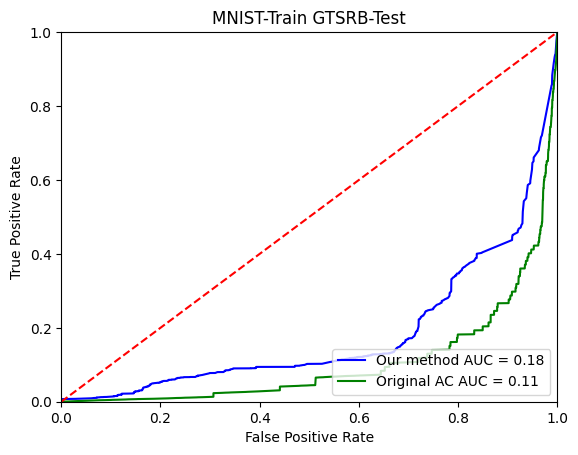

In [27]:

fpr_orig, tpr_orig, threshold_orig = metrics.roc_curve(test_lables, test_df.all_sample_silhuette.values)
roc_auc_orig = metrics.auc(fpr_orig, tpr_orig)

plt.title('MNIST-Train GTSRB-Test')
plt.plot(fpr, tpr, 'b', label = 'Our method AUC = %0.2f' % roc_auc)
plt.plot(fpr_orig, tpr_orig, 'g', label = 'Original AC AUC = %0.2f' % roc_auc_orig)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc_score(test_lables, preds_proba[:, 1])=0.5608095822209624
f1_score(test_lables, preds_class)=0.06750880277896298


In [133]:
print(f"{roc_auc_score(test_lables, test_df.all_sample_silhuette)=}")
print(f"{f1_score(test_lables, test_df.all_sample_silhuette > 0.11)=}")

roc_auc_score(test_lables, test_df.all_sample_silhuette)=0.49926169249181157
f1_score(test_lables, test_df.all_sample_silhuette > 0.11)=0.170708229804829


In [23]:
# тестируем на каждом датасете отдельно

for dname in datasets:
    preds_proba = model.predict_proba(test_datasets_dict[dname].values)
    preds_class = model.predict(test_datasets_dict[dname].values)
    print(f"{dname}: {roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=}")
    print(f"{dname}: {f1_score(test_lables_dict[dname], preds_class)=}")

mnist: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=1.0
mnist: f1_score(test_lables_dict[dname], preds_class)=0.9999218811030388
cifar10: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9982150723828125
cifar10: f1_score(test_lables_dict[dname], preds_class)=0.9450021583691169
cifar100: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=1.0
cifar100: f1_score(test_lables_dict[dname], preds_class)=0.9985552154226852
gtsrb: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9999999874321522
gtsrb: f1_score(test_lables_dict[dname], preds_class)=0.9946909676440732


In [1]:
fi = model.get_feature_importance()
fi_list = []
for feature_importance in zip(fi[fi > 0], train_df.columns[fi > 0]):
    fi_list.append(feature_importance)

fi_list.sort()
fi_list

NameError: name 'model' is not defined

In [28]:
test_df_1 = test_df.drop(['all_clusters', 'all_pred_label'], axis=1)
train_df_1 = train_df.drop(['all_clusters', 'all_pred_label'], axis=1)

In [ ]:
model = CatBoostClassifier()
model.fit(train_df_1.values, train_lables)

In [30]:
# тестируем на всём тесте
preds_proba = model.predict_proba(test_df_1.values)
preds_class = model.predict(test_df_1.values)
print(f"{roc_auc_score(test_lables, preds_proba[:, 1])=}")
print(f"{f1_score(test_lables, preds_class)=}")

roc_auc_score(test_lables, preds_proba[:, 1])=0.998943806861812
f1_score(test_lables, preds_class)=0.9811665373190247


In [33]:
test_datasets_dict_1 = {}
for k, v in test_datasets_dict.items():
    test_datasets_dict_1[k] = v.drop(['all_clusters', 'all_pred_label'], axis=1)

In [34]:
# тестируем на каждом датасете отдельно

for dname in datasets:
    preds_proba = model.predict_proba(test_datasets_dict_1[dname].values)
    preds_class = model.predict(test_datasets_dict_1[dname].values)
    print(f"{dname}: {roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=}")
    print(f"{dname}: {f1_score(test_lables_dict[dname], preds_class)=}")

mnist: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9999975049581646
mnist: f1_score(test_lables_dict[dname], preds_class)=0.9998073287960133
cifar10: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9964540307552083
cifar10: f1_score(test_lables_dict[dname], preds_class)=0.9608213335734893
cifar100: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9999986111111111
cifar100: f1_score(test_lables_dict[dname], preds_class)=0.9828311680334162
gtsrb: roc_auc_score(test_lables_dict[dname], preds_proba[:, 1])=0.9999951690538762
gtsrb: f1_score(test_lables_dict[dname], preds_class)=0.9733117924770652


In [36]:
fi = model.get_feature_importance()
fi_list = []
for feature_importance in zip(fi[fi > 0], test_df_1.columns[fi > 0]):
    fi_list.append(feature_importance)

fi_list.sort()
fi_list

[(0.43392854386260277,
  'all_sample_mean_distance_to_cluster_centroid_amoung_cluster'),
 (0.4695390127898757, 'all_sample_activation_norm'),
 (0.7478298030289534, 'nb_classes'),
 (2.364341846943206, 'all_sample_relative_cluster_size'),
 (14.233874080319405, 'all_sample_min_distance_to_other_classes'),
 (14.80500256315978, 'all_sample_distance_to_cluster_centroid'),
 (17.674429852359925, 'classifier_ensurance'),
 (18.695393059584323, 'all_sample_silhuette'),
 (30.575661237951934, 'image_size')]